In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, f1_score, roc_auc_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from statistics import mean
from tabulate import tabulate
import seaborn as sns

from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/datasets_csv/final_data.csv')

In [ ]:
cleaned_data = data.drop(['Unnamed: 0','dob','driverId','constructorId','date','DNF (Constructor Fault)', 'DNF (Driver Error)','DNF','Constructor Win',
                                   'circuitId','Country','Race Position'], axis=1)

0.0    15315
1.0      687
Name: Driver Win, dtype: int64


<Axes: >

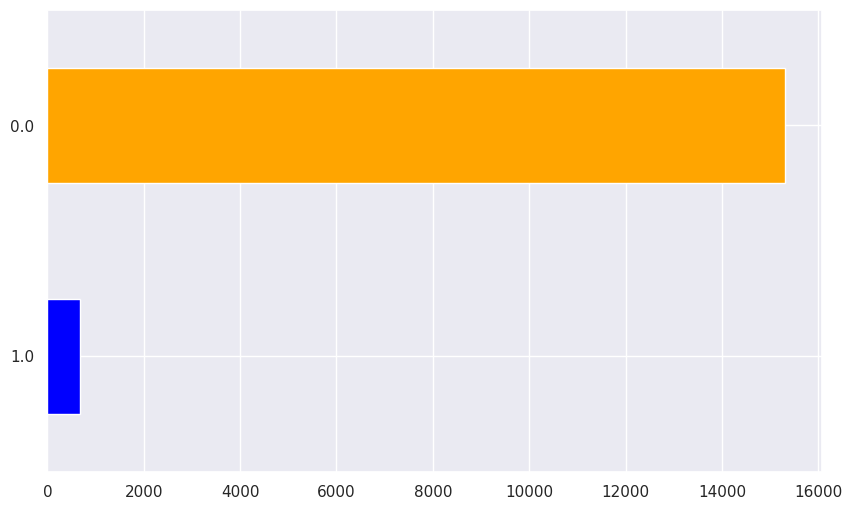

In [ ]:
print(cleaned_data['Driver Win'].value_counts())
color = ['blue','orange']
cleaned_data['Driver Win'].value_counts().sort_values().plot(kind = 'barh', color = color)
#We have an imbalanced dataset

In [ ]:
season = 2018
data_season= cleaned_data[cleaned_data['year']<(season+1)]

encoder = LabelEncoder()
data_season['Grand Prix Name'] = encoder.fit_transform(data_season['Grand Prix Name'])
data_season['Constructor Name'] = encoder.fit_transform(data_season['Constructor Name'])
data_season['Driver Name'] = encoder.fit_transform(data_season['Driver Name'])
data_season['Driver Nationality'] = encoder.fit_transform(data_season['Driver Nationality'])
data_season['Constructor Nationality'] = encoder.fit_transform(data_season['Constructor Nationality'])


data_test = data_season[data_season['year']==season]
data_train = data_season[data_season['year']<season]

X = data_train.drop('Driver Win',axis=1)
y = data_train['Driver Win']
X_test = data_test.drop('Driver Win',axis=1)
y_test = data_test['Driver Win']

<ipython-input-223-8bb34d28d27d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_season['Grand Prix Name'] = encoder.fit_transform(data_season['Grand Prix Name'])
<ipython-input-223-8bb34d28d27d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_season['Constructor Name'] = encoder.fit_transform(data_season['Constructor Name'])
<ipython-input-223-8bb34d28d27d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Resampled dataset shape Counter({0.0: 13130, 1.0: 13130})


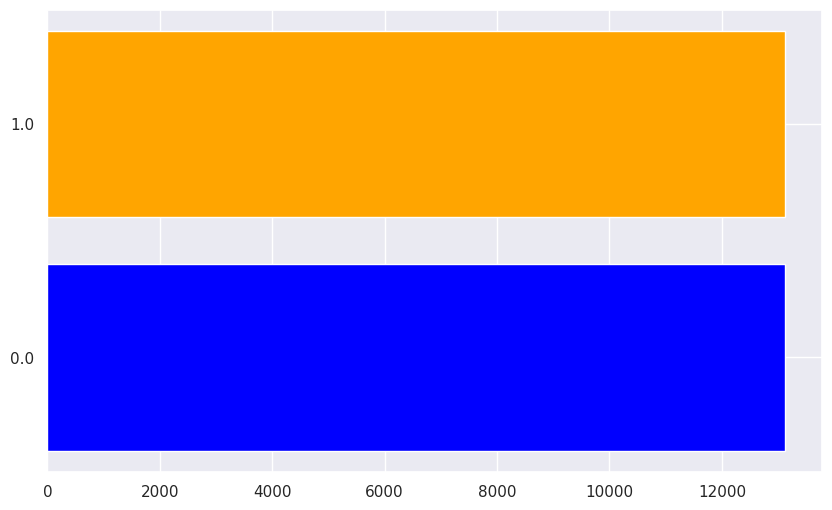

In [ ]:
#Balancing our dataset with oversampling to avoid lossing information and taking into account that the dataset is not huge

# rus = RandomUnderSampler(random_state=42)
# X_res, y_res = rus.fit_resample(X, y)
# print('Resampled dataset shape %s' % Counter(y_res))

ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))
color = ['blue','orange']
plt.barh(range(len(Counter(y_res))), list(Counter(y_res).values()), align='center', color = color)
plt.yticks(range(len(Counter(y_res))), list(Counter(y_res).keys()))
plt.show()

**Score Function**:
Taking into account that the predictions should be done by races and the models more often than not predict several winners or no winner for the races, a scoring fuction is defined. This function considered the winner as the driver with the highest probability of winning the race. The precision_score function will give the score for each individual round and the scoring fucntion will get the mean value of the precisions_scores of the entire season.

In [ ]:
def scoring_scaled(model):

  data_score = data_test.copy()
  score_pre = []
  score_f1 = []
  score_roc_auc = []
  score_recall = []

  for round in  data_score[data_score['year']==season]['round']:


    data_event = data_score[( data_score['year']==season) & ( data_score['round']==round)]
    X_test_1 = data_event.drop('Driver Win',axis=1)
    y_test = data_event['Driver Win']

    X_test_event = pd.DataFrame(scaler.transform(X_test_1), columns = X_test_1.columns)

    probability = model.predict_proba(X_test_event)

    X_score_event = X_test_event.copy()
    X_score_event['Probability'] = probability[:,1]
    X_score_event['Actual Win'] = y_test.reset_index(drop = True)
    X_score_event = X_score_event.sort_values(by = 'Probability', ascending = False)
    X_score_event.reset_index(inplace = True, drop = True)
    X_score_event ['predicted'] = X_score_event['Probability']
    max = X_score_event ['predicted'].max()
    X_score_event ['predicted'] = X_score_event ['predicted'].apply(lambda x: 1  if x==max else 0)
    score_pre.append(precision_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_f1.append(f1_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_recall.append(recall_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_roc_auc.append(roc_auc_score(X_score_event['Actual Win'], X_score_event['Probability']))

  score_pre_model = mean(score_pre)
  score_f1_model = mean(score_f1)
  score_roc_auc_model = mean(score_roc_auc)
  score_recall_model = mean(score_recall)
  print('training.........')

  return(score_pre_model, score_recall_model, score_f1_model, score_roc_auc_model)



In [ ]:
def scoring(model):

  data_score = data_test.copy()
  score_pre = []
  score_f1 = []
  score_roc_auc = []
  score_recall = []

  for round in  data_score[data_score['year']==season]['round']:


    data_event = data_score[( data_score['year']==season) & ( data_score['round']==round)]
    X_test_1 = data_event.drop('Driver Win',axis=1)
    y_test = data_event['Driver Win']

    probability = model.predict_proba(X_test_1)

    X_score_event = X_test_1.copy()
    X_score_event['Probability'] = probability[:,1]
    X_score_event['Actual Win'] = y_test
    X_score_event = X_score_event.sort_values(by = 'Probability', ascending = False)
    X_score_event.reset_index(inplace = True, drop = True)
    X_score_event ['predicted'] = X_score_event['Probability']
    max = X_score_event ['predicted'].max()
    X_score_event ['predicted'] = X_score_event ['predicted'].apply(lambda x: 1  if x==max else 0)
    score_pre.append(precision_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_f1.append(f1_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_recall.append(recall_score(X_score_event['Actual Win'], X_score_event['predicted']))
    score_roc_auc.append(roc_auc_score(X_score_event['Actual Win'], X_score_event['Probability']))

  score_pre_model = mean(score_pre)
  score_f1_model = mean(score_f1)
  score_roc_auc_model = mean(score_roc_auc)
  score_recall_model = mean(score_recall)
  print('training.........')

  return(score_pre_model, score_recall_model, score_f1_model, score_roc_auc_model)

**Spot checking Algorithms**

In [ ]:
scaler = StandardScaler()
X_res_scaled = pd.DataFrame(scaler.fit_transform(X_res), columns = X_res.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [ ]:
#knn
knn = KNeighborsClassifier().fit(X_res_scaled,y_res)
scoring_scaled(knn)

training.........


(0.10606060606060606,
 0.18181818181818182,
 0.12878787878787878,
 0.7715311004784688)

In [ ]:
#Logistic Regression
lr = LogisticRegression().fit(X_res_scaled,y_res)
scoring_scaled(lr)

training.........


(0.45454545454545453,
 0.45454545454545453,
 0.45454545454545453,
 0.8923444976076556)

In [ ]:
#SVC
svc = SVC(kernel = 'linear', probability=True).fit(X_res_scaled,y_res)
scoring_scaled(svc)

training.........


(0.45454545454545453,
 0.45454545454545453,
 0.45454545454545453,
 0.8827751196172249)

In [ ]:
#Naive Bayes
GNB = GaussianNB().fit(X_res,y_res)
scoring(GNB)

training.........


(0.2727272727272727,
 0.2727272727272727,
 0.2727272727272727,
 0.8755980861244019)

In [ ]:
#RandomForest Model
RF = RandomForestClassifier(n_estimators = 1000, random_state=0).fit(X_res,y_res)
scoring(RF)

training.........


(0.4090909090909091,
 0.4090909090909091,
 0.4090909090909091,
 0.9234449760765551)

In [ ]:
#Gradient Boosting Decision Trees
GBDT = GradientBoostingClassifier(n_estimators = 1000, max_depth = 5, random_state = 0).fit(X_res,y_res)
scoring(GBDT)

training.........


(0.18181818181818182,
 0.18181818181818182,
 0.18181818181818182,
 0.7081339712918661)

In [ ]:
#Neural Networks
nn = MLPClassifier(hidden_layer_sizes = [10,10], activation = 'tanh', solver = 'lbfgs',random_state = 0).fit(X_res_scaled,y_res)
scoring_scaled(nn)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


training.........


(0.13636363636363635,
 0.13636363636363635,
 0.13636363636363635,
 0.8444976076555024)

**Parameter selection for choosing best algorithm**

In [ ]:
#KNN------------------------
comparison_dict_knn = {'model':[],
                      'n_neighbors': [],
                      'weights': [],
                      'precision_score': [],
                      'recall_score': [],
                      'f1_score': [],
                      'roc_auc_score': []}

params={'n_neighbors': [1,2,3,4,5,10,20,40,50],
        'weights': ['uniform','distance']}


print('training.........')
for n_neighbors in params['n_neighbors']:
    for weights in params['weights']:
          model = KNeighborsClassifier(n_neighbors = n_neighbors, weights = weights, n_jobs = -1)
          model.fit(X_res_scaled,y_res)

          precision, recall, f1, roc_auc = scoring_scaled(model)

          comparison_dict_knn['model'].append('KNeighborsClassifier')
          comparison_dict_knn['n_neighbors'].append(n_neighbors)
          comparison_dict_knn['weights'].append(weights)
          comparison_dict_knn['precision_score'].append(precision)
          comparison_dict_knn['recall_score'].append(recall)
          comparison_dict_knn['f1_score'].append(f1)
          comparison_dict_knn['roc_auc_score'].append(roc_auc)
          print('training for weights {} '.format(weights))

          df_knn = pd.DataFrame(comparison_dict_knn)

          df_knn.to_csv('/content/drive/MyDrive/Colab Notebooks/results_knn.csv', index=False, header=True)

    print('training for n_neighbors {} '.format(n_neighbors))

df_knn = pd.DataFrame(comparison_dict_knn)


# Logistic Regression-------------------------
comparison_dict_lr = {'model':[],
                      'penalty': [],
                      'solver': [],
                      'C': [],
                      'precision_score': [],
                      'recall_score': [],
                      'f1_score': [],
                      'roc_auc_score': []}

params={'penalty': ['l1', 'l2'],
        'solver': ['saga', 'liblinear'],
       'C': np.logspace(-3,3,10)}

print('training.........')
for penalty in params['penalty']:
    for solver in params['solver']:
        for c in params['C']:
            model_params = (penalty, solver, c)
            model = LogisticRegression(penalty = penalty, solver = solver, C = c, max_iter = 10000, n_jobs=-1)
            model.fit(X_res_scaled,y_res)

            precision, recall, f1, roc_auc = scoring_scaled(model)

            comparison_dict_lr['model'].append('logistic_regression')
            comparison_dict_lr['penalty'].append(penalty)
            comparison_dict_lr['solver'].append(solver)
            comparison_dict_lr['C'].append(c)
            comparison_dict_lr['precision_score'].append(precision)
            comparison_dict_lr['recall_score'].append(recall)
            comparison_dict_lr['f1_score'].append(f1)
            comparison_dict_lr['roc_auc_score'].append(roc_auc)

            df_knn = pd.DataFrame(comparison_dict_knn)

            df_knn.to_csv('/content/drive/MyDrive/Colab Notebooks/results_knn.csv', index=False, header=True)

        print('training.........')
    print('training.........')

# SVC-------------------------
comparison_dict_svc = {'model':[],
                      'gamma': [],
                      'kernel': [],
                      'C': [],
                      'precision_score': [],
                      'recall_score': [],
                      'f1_score': [],
                      'roc_auc_score': []}

params={'kernel': ['rbf', 'sigmoid', 'linear'],
        'gamma': np.logspace(-5,3,5),
       'C': np.logspace(-3,3,5)}


print('training.........')
for kernel in params['kernel']:
    for gamma in params['gamma']:
        for c in params['C']:
            model_params = (kernel, gamma, c)
            model = SVC(kernel = kernel, gamma = gamma, C = c, probability=True)
            model.fit(X_res_scaled,y_res)

            precision, recall, f1, roc_auc = scoring_scaled(model)

            comparison_dict_svc['model'].append('SVC')
            comparison_dict_svc['kernel'].append(kernel)
            comparison_dict_svc['gamma'].append(gamma)
            comparison_dict_svc['C'].append(c)
            comparison_dict_svc['precision_score'].append(precision)
            comparison_dict_svc['recall_score'].append(recall)
            comparison_dict_svc['f1_score'].append(f1)
            comparison_dict_svc['roc_auc_score'].append(roc_auc)
            print('training for C{}.........'.format(c))

            df_lr = pd.DataFrame(comparison_dict_svc)
            df_lr.to_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/results_svc4.csv', index=False, header=True)

        print('training for gamma: {}.........'.format(gamma))
    print('training for kernel: {}.........'.format(kernel))


#Random Forest------------------------
comparison_dict_rf = {'model':[],
                      'n_estimators': [],
                      'max_depth': [],
                      'max_features': [],
                      'precision_score': [],
                      'recall_score': [],
                      'f1_score': [],
                      'roc_auc_score': []}

params={'n_estimators': [100,500,1000,1200,1400,1600,2000,2200],
        'max_depth': [3,5,8],
       'max_features': [1,2,5,10]}


print('training.........')
for n_estimators in params['n_estimators']:
    for max_depth in params['max_depth']:
        for max_features in params['max_features']:
            model = RandomForestClassifier(n_estimators = n_estimators, max_depth = max_depth, max_features = max_features, n_jobs=-1, random_state=0)
            model.fit(X_res,y_res)

            precision, recall, f1, roc_auc = scoring(model)

            comparison_dict_rf['model'].append('RandomForest')
            comparison_dict_rf['n_estimators'].append(n_estimators)
            comparison_dict_rf['max_depth'].append(max_depth)
            comparison_dict_rf['max_features'].append(max_features)
            comparison_dict_rf['precision_score'].append(precision)
            comparison_dict_rf['recall_score'].append(recall)
            comparison_dict_rf['f1_score'].append(f1)
            comparison_dict_rf['roc_auc_score'].append(roc_auc)
            print('training for max_features {} '.format(max_features))

            df_lr = pd.DataFrame(comparison_dict_rf)

            df_lr.to_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/results_rf2.csv', index=False, header=True)

        print('training for max_depth {} '.format(max_depth))
    print('training for n_estimators {} '.format(n_estimators))

#Gradient Boostig Decision Tree------------------------
comparison_dict_gbdt = {'model':[],
                      'n_estimators': [],
                      'max_depth': [],
                      'learning_rate': [],
                      'precision_score': [],
                      'recall_score': [],
                      'f1_score': [],
                      'roc_auc_score': []}

params={'n_estimators': [100,500,1000,1200,1400,1600,2000,2200],
        'max_depth': [3,5],
       'learning_rate': [0.0001,0.001,0.01,0.1]}


print('training.........')
for n_estimators in params['n_estimators']:
    for max_depth in params['max_depth']:
        for learning_rate in params['learning_rate']:
            model = GradientBoostingClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, random_state=0)
            model.fit(X_res,y_res)

            precision, recall, f1, roc_auc = scoring(model)

            comparison_dict_gbdt['model'].append('GradietnBoostingDecisionTree')
            comparison_dict_gbdt['n_estimators'].append(n_estimators)
            comparison_dict_gbdt['max_depth'].append(max_depth)
            comparison_dict_gbdt['learning_rate'].append(learning_rate)
            comparison_dict_gbdt['precision_score'].append(precision)
            comparison_dict_gbdt['recall_score'].append(recall)
            comparison_dict_gbdt['f1_score'].append(f1)
            comparison_dict_gbdt['roc_auc_score'].append(roc_auc)
            print('training for max_features {} '.format(learning_rate))

            df_lr = pd.DataFrame(comparison_dict_gbdt)

            df_lr.to_csv('/content/drive/MyDrive/Colab Notebooks/results_gbdt.csv', index=False, header=True)

        print('training for max_depth {} '.format(max_depth))
    print('training for n_estimators {} '.format(n_estimators))

#Neural Network------------------------
comparison_dict_knn = {'model':[],
                      'hidden_layer_sizes': [],
                      'activation': [],
                      'solver': [],
                      'alpha': [],
                      'precision_score': [],
                      'recall_score': [],
                      'f1_score': [],
                      'roc_auc_score': []}

params={'hidden_layer_sizes': [(10,10,10,10), (70,20,45,10)],
                      'activation': ['tanh', 'relu', 'logistic', 'identity'],
                      'solver': ['adam', 'sgd', 'lbfgs'],
                      'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1,1]}


print('training.........')
for hidden_layer_sizes in params['hidden_layer_sizes']:
    for activation in params['activation']:
      for solver in params['solver']:
        for alpha in params['alpha']:

          model = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = activation, solver = solver, alpha = alpha, max_iter = 500,random_state = 0)
          model.fit(X_res_scaled,y_res)

          precision, recall, f1, roc_auc = scoring_scaled(model)

          comparison_dict_knn['model'].append('MLPClassifier')
          comparison_dict_knn['hidden_layer_sizes'].append(hidden_layer_sizes)
          comparison_dict_knn['activation'].append(activation)
          comparison_dict_knn['solver'].append(solver)
          comparison_dict_knn['alpha'].append(alpha)
          comparison_dict_knn['precision_score'].append(precision)
          comparison_dict_knn['recall_score'].append(recall)
          comparison_dict_knn['f1_score'].append(f1)
          comparison_dict_knn['roc_auc_score'].append(roc_auc)

          print('training for alpha {} '.format(alpha))

          df_knn = pd.DataFrame(comparison_dict_knn)

          df_knn.to_csv('/content/drive/MyDrive/Colab Notebooks/results_nn.csv', index=False, header=True)

        print('training for solver {} '.format(solver))
      print('training for activation {} '.format(activation))
    print('training for hidden_layer {} '.format(hidden_layer_sizes))

In [4]:
results_knn = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/results_knn.csv')
results_lr = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/results_lr.csv')
results_svc = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/results_svc.csv')
results_RF = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/results_rf.csv')
results_GBDT = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/results_gbdt.csv')
results_NN = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/results_nn.csv')


In [5]:
max_result_knn = results_knn.precision_score.max()
max_result_lr = results_lr.precision_score.max()
max_result_svc = results_svc.precision_score.max()
max_result_RF = results_RF.precision_score.max()
max_result_GBDT = results_GBDT.precision_score.max()
max_result_NN = results_NN.precision_score.max()

results_data_training = [['KNN', max_result_knn],
                         ['LR', max_result_lr],
                         ['SVC', max_result_svc],
                         ['RF', max_result_RF],
                         ['GBDT', max_result_GBDT],
                         ['Neural Network', max_result_NN]]

results_2018 = pd.DataFrame(results_data_training, columns = ['Model', 'precision_score_2018'])


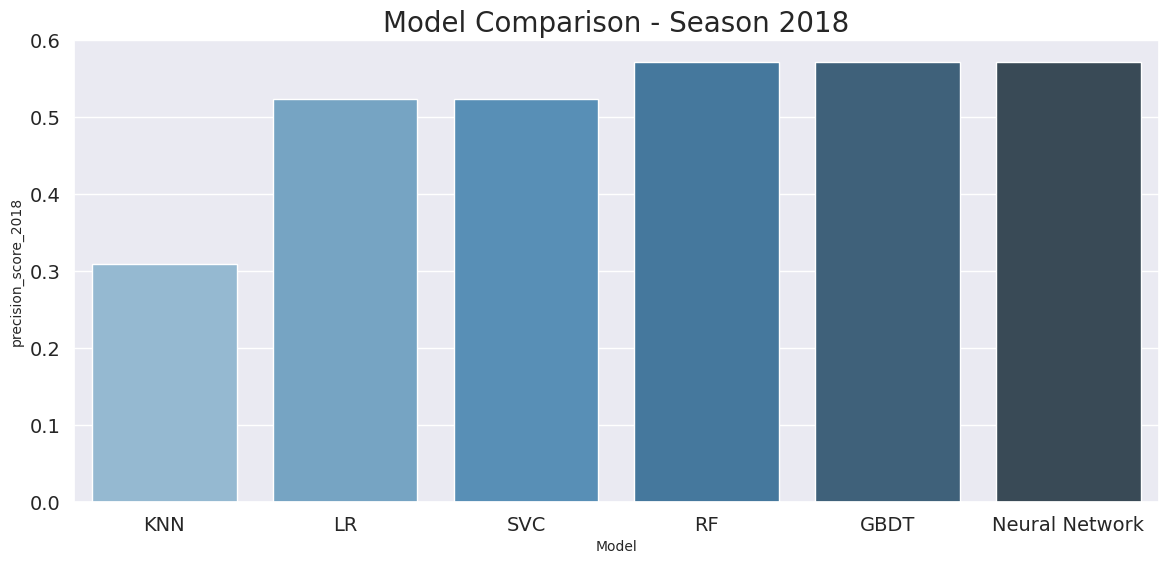

In [9]:
ax = sns.barplot(x = results_2018.Model, y = results_2018.precision_score_2018, palette=("Blues_d"))
sns.set_context("poster")

sns.set(rc={'figure.figsize':(12,6)})
plt.xlabel('Model', fontsize=10);
plt.ylabel('precision_score_2018', fontsize=10);
plt.title('Model Comparison - Season 2018', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
params_knn = {'n_neighbors': results_knn[results_knn['precision_score'] == max_result_knn].iloc[0]['n_neighbors'],
              'weights': results_knn[results_knn['precision_score'] == max_result_knn].iloc[0]['weights']}

params_lr = {'penalty': results_lr[results_lr['precision_score'] == max_result_lr].iloc[0]['penalty'],
             'solver': results_lr[results_lr['precision_score'] == max_result_lr].iloc[0]['solver'],
             'C': results_lr[results_lr['precision_score'] == max_result_lr].iloc[0]['C'],}

params_svc = {'gamma': results_svc[results_svc['precision_score'] == max_result_svc].iloc[0]['gamma'],
              'kernel': results_svc[results_svc['precision_score'] == max_result_svc].iloc[0]['kernel'],
              'C': results_svc[results_svc['precision_score'] == max_result_svc].iloc[0]['C']}

params_RF = {'n_estimators': results_RF[results_RF['precision_score'] == max_result_RF].iloc[0]['n_estimators'],
             'max_depth': results_RF[results_RF['precision_score'] == max_result_RF].iloc[0]['max_depth'],
             'max_features': results_RF[results_RF['precision_score'] == max_result_RF].iloc[0]['max_features']}

params_GBDT = {'n_estimators': results_GBDT[results_GBDT['precision_score'] == max_result_GBDT].iloc[0]['n_estimators'],
             'max_depth': results_GBDT[results_GBDT['precision_score'] == max_result_GBDT].iloc[0]['max_depth'],
             'learning_rate': results_GBDT[results_GBDT['precision_score'] == max_result_GBDT].iloc[0]['learning_rate']}


params_NN = {'hidden_layer_sizes': results_NN[results_NN['precision_score'] == max_result_NN].iloc[0]['hidden_layer_sizes'],
             'activation': results_NN[results_NN['precision_score'] == max_result_NN].iloc[0]['activation'],
             'solver': results_NN[results_NN['precision_score'] == max_result_NN].iloc[0]['solver'],
             'alpha': results_NN[results_NN['precision_score'] == max_result_NN].iloc[0]['alpha']}

**Testing the best models**

In [ ]:
RF_clf2 = RandomForestClassifier(n_estimators= 500, max_depth= 5, max_features= 5, random_state = 0).fit(X_res,y_res)
y_predict_clf2 = RF_clf2.predict(X_test)
proba = RF_clf2.predict_proba(X_test)
scoring(RF_clf2)

training.........


(0.5714285714285714,
 0.5714285714285714,
 0.5714285714285714,
 0.9423558897243108)

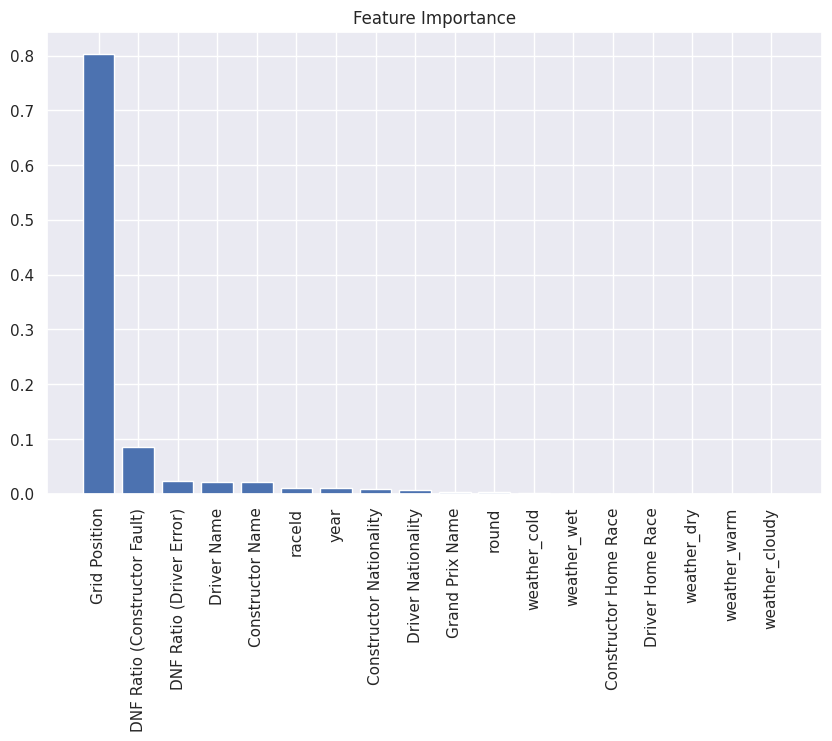

In [ ]:

# Get feature importances
importances = RF_clf2.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [X.columns[i] for i in indices]

# Create plot
plt.figure()

# Create plot title
plt.title("Feature Importance")

# Add bars
plt.bar(range(X.shape[1]), importances[indices])

# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=90)

# Show plot
plt.show()

**Testing the models on the seasons 2017 and 2019, the ones adjacent to the 2018 season**

In [2]:
results_2019 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/test_2019.csv')
results_2017 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ML_F1_Project/Results_csv/test_2017.csv')

In [10]:
new_results = pd.merge(results_2017,results_2018, how = 'inner',on = 'Model')
new_results_2 = pd.merge(new_results,results_2019, how = 'inner',on = 'Model')

In [11]:
new_results_2
new_results_2.set_index('Model', inplace = True)

In [12]:
avg_model_results = new_results_2.mean(axis = 1)

In [13]:
avg_model_results

Model
KNN               0.338889
LR                0.500794
SVC               0.531746
RF                0.533333
GBDT              0.531746
Neural Network    0.579365
dtype: float64

In [14]:
avg_model_results.idxmax(), avg_model_results.max()

('Neural Network', 0.5793650793650794)